# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1+cpu


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names =  ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/lung_opacity'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral_pneumonia examples
Found 3586 covid examples
Found 5982 lung_opacity examples


In [6]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/test/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/test/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/test/lung_opacity'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral_pneumonia examples
Found 30 covid examples
Found 30 lung_opacity examples


In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 3508
Number of test batches 20


# Data Visualization

In [8]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

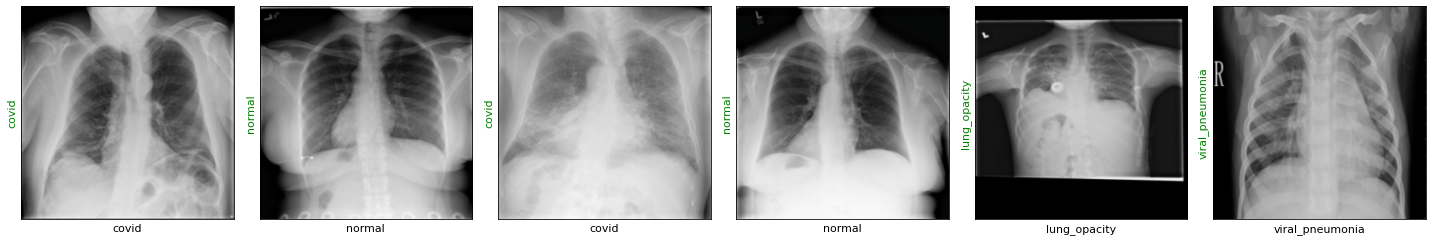

In [144]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

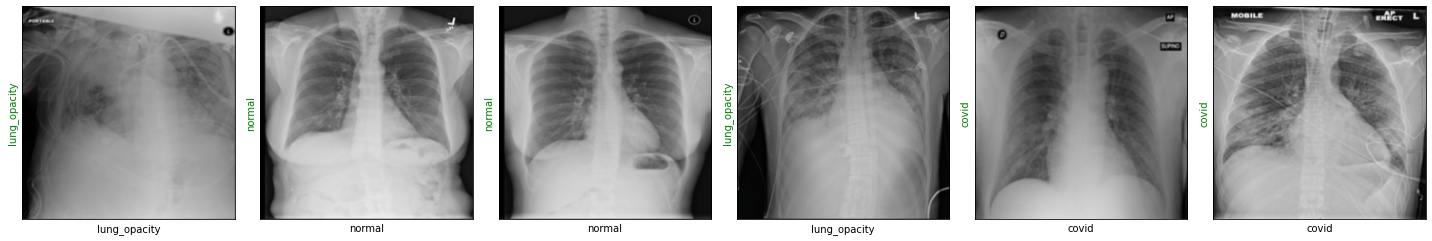

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

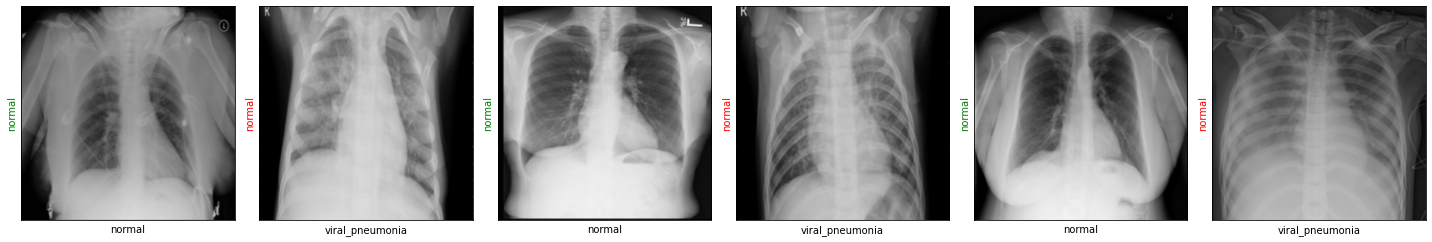

In [14]:
show_preds()

# Training the Model

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.8235, Accuracy: 0.2333


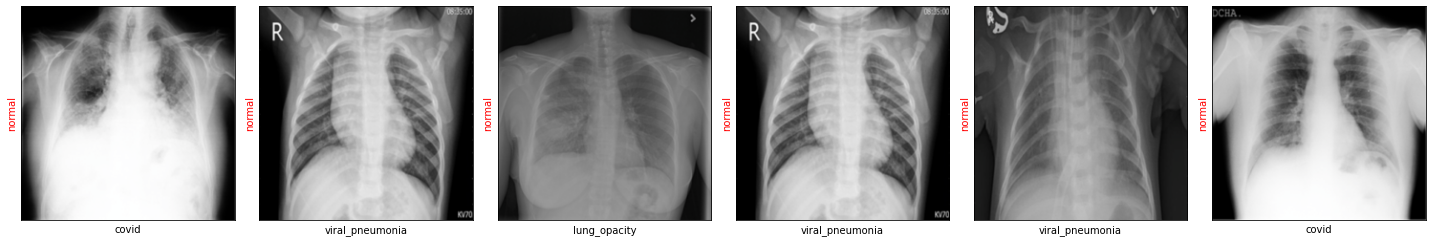

Evaluating at step 20
Validation Loss: 1.3178, Accuracy: 0.4250


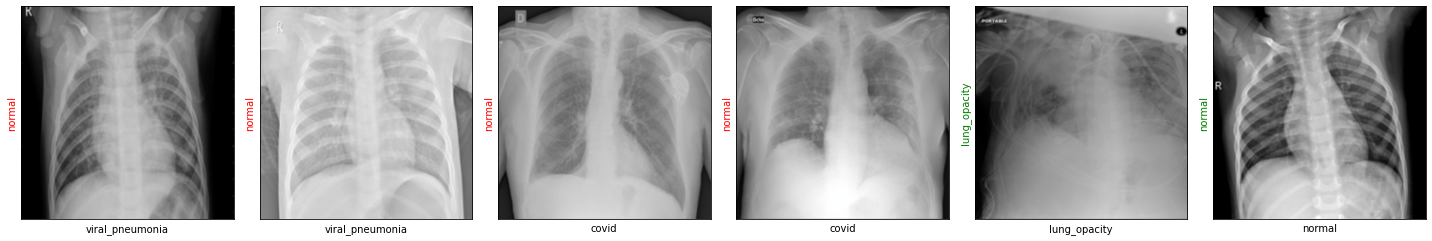

Evaluating at step 40
Validation Loss: 1.0265, Accuracy: 0.6417


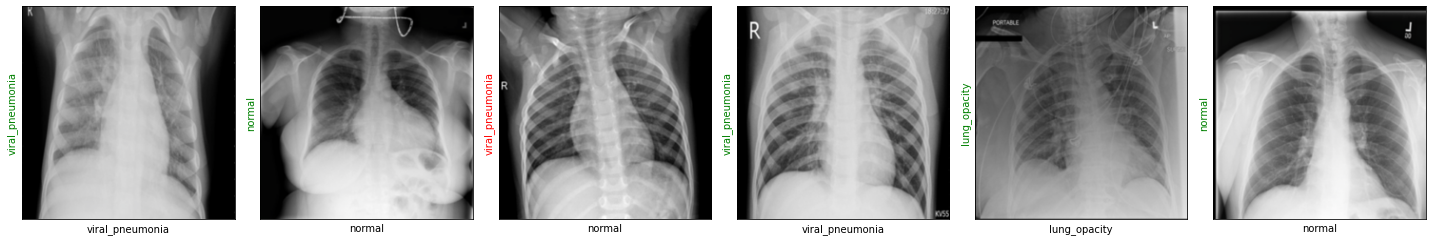

Evaluating at step 60
Validation Loss: 0.7388, Accuracy: 0.6667


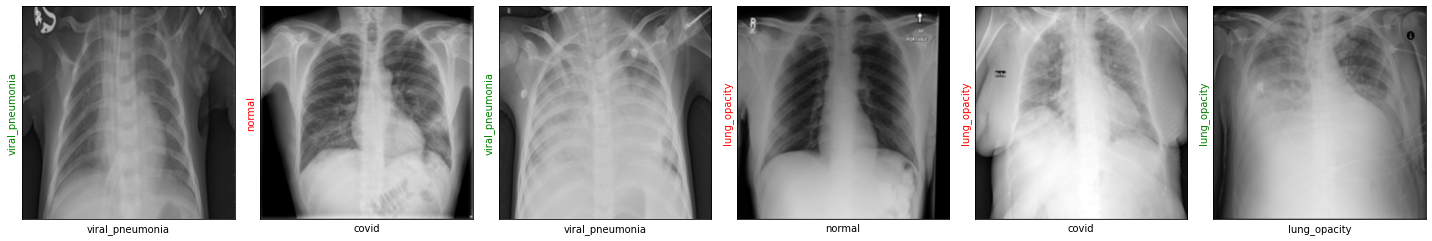

Evaluating at step 80
Validation Loss: 0.5523, Accuracy: 0.8250


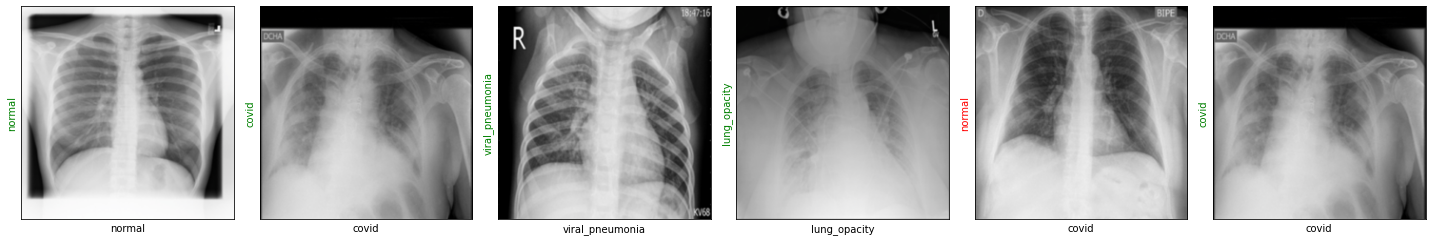

Evaluating at step 100
Validation Loss: 0.5160, Accuracy: 0.8333


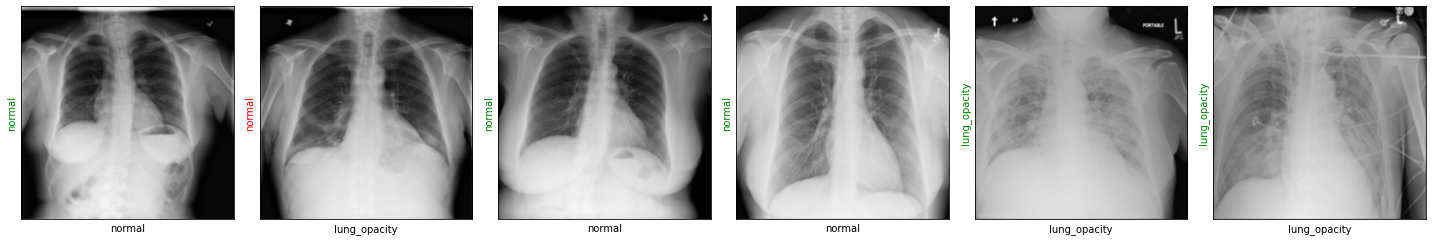

Evaluating at step 120
Validation Loss: 0.4827, Accuracy: 0.8167


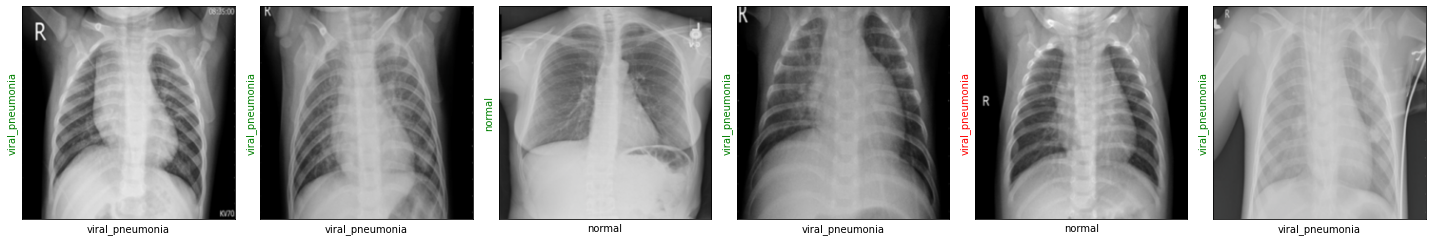

Evaluating at step 140
Validation Loss: 0.4458, Accuracy: 0.8750


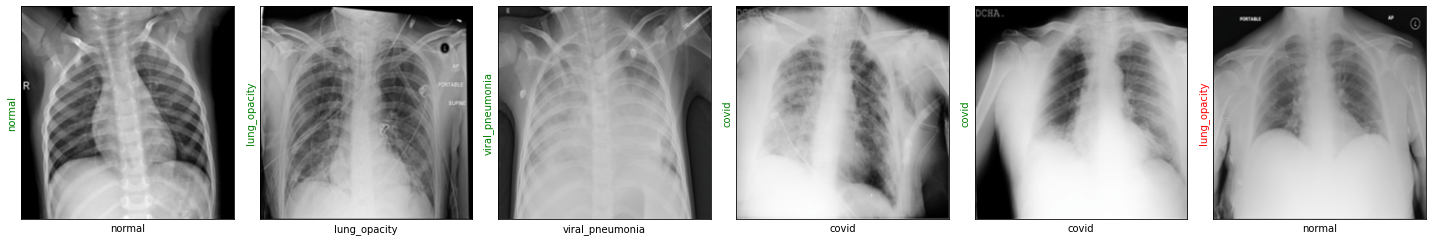

Evaluating at step 160
Validation Loss: 0.4312, Accuracy: 0.8583


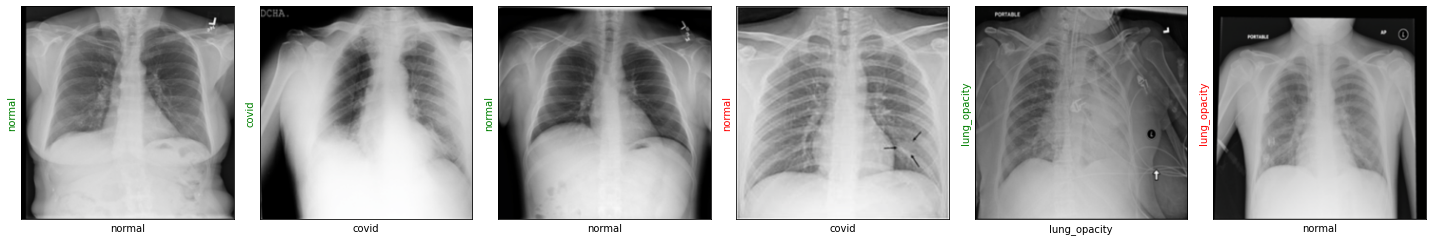

Evaluating at step 180
Validation Loss: 0.3919, Accuracy: 0.8583


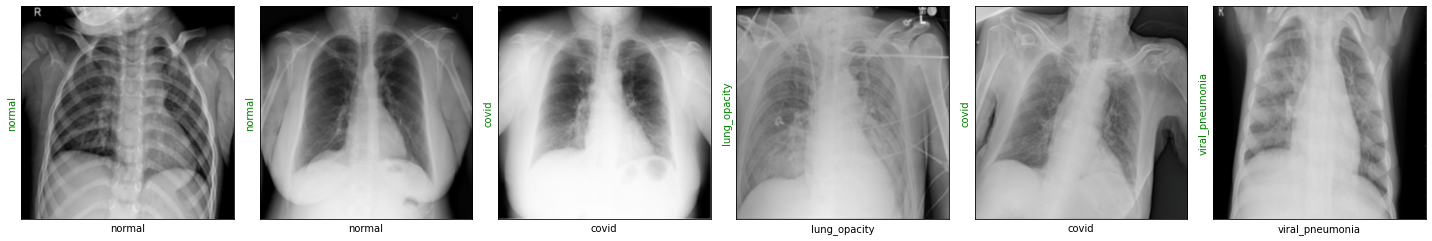

Evaluating at step 200
Validation Loss: 0.3781, Accuracy: 0.8500


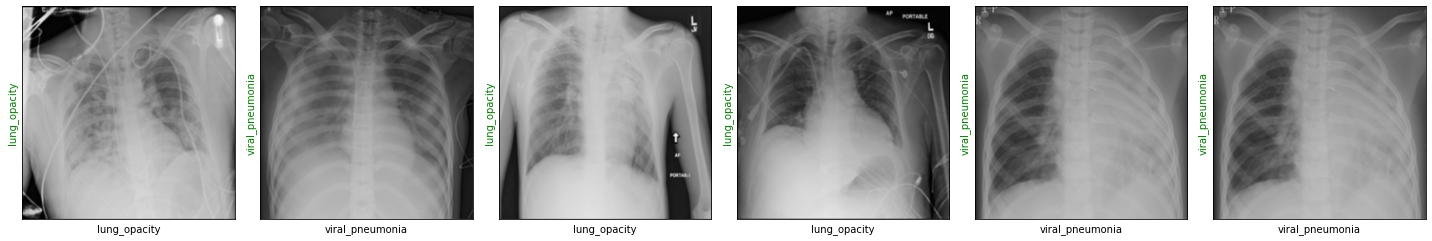

Evaluating at step 220
Validation Loss: 0.4301, Accuracy: 0.8167


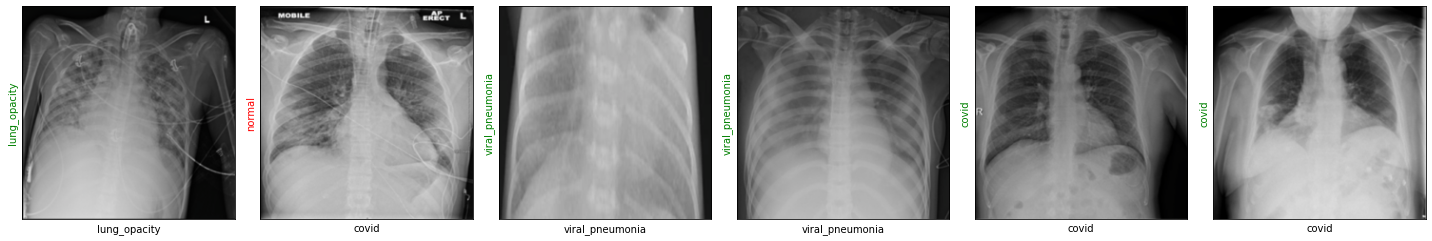

Evaluating at step 240
Validation Loss: 0.3197, Accuracy: 0.9167


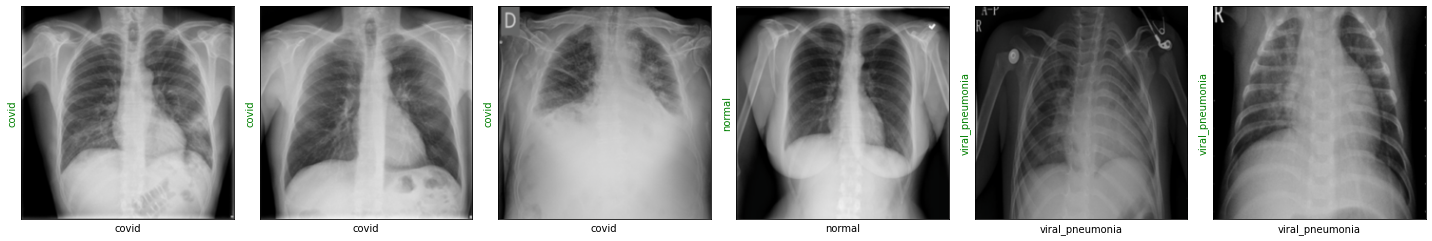

Evaluating at step 260
Validation Loss: 0.3345, Accuracy: 0.8667


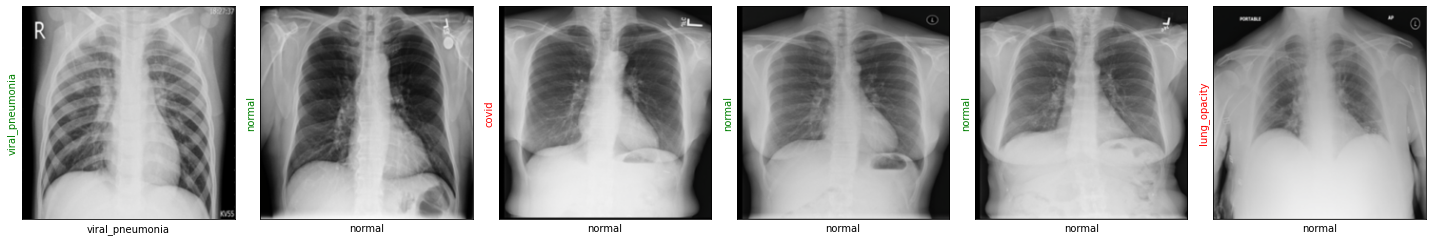

Evaluating at step 280
Validation Loss: 0.2180, Accuracy: 0.9167


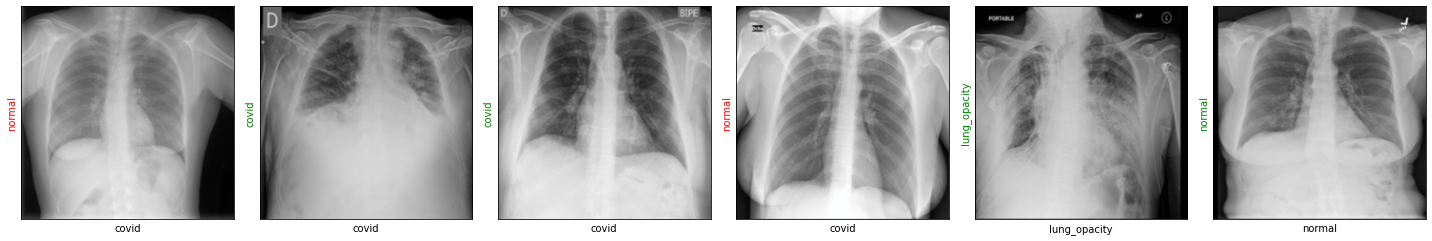

Evaluating at step 300
Validation Loss: 0.3391, Accuracy: 0.8750


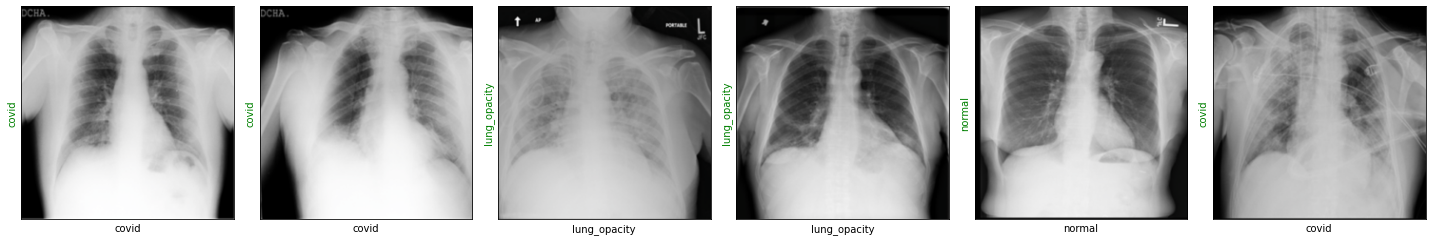

Evaluating at step 320
Validation Loss: 0.3374, Accuracy: 0.8917


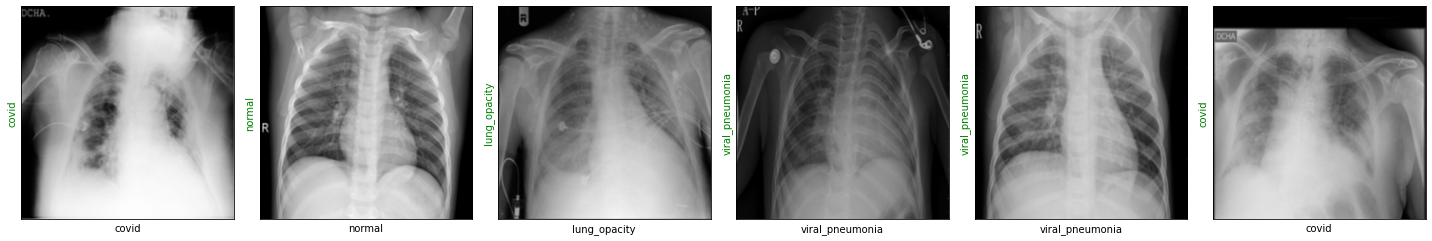

Evaluating at step 340
Validation Loss: 0.1974, Accuracy: 0.9500


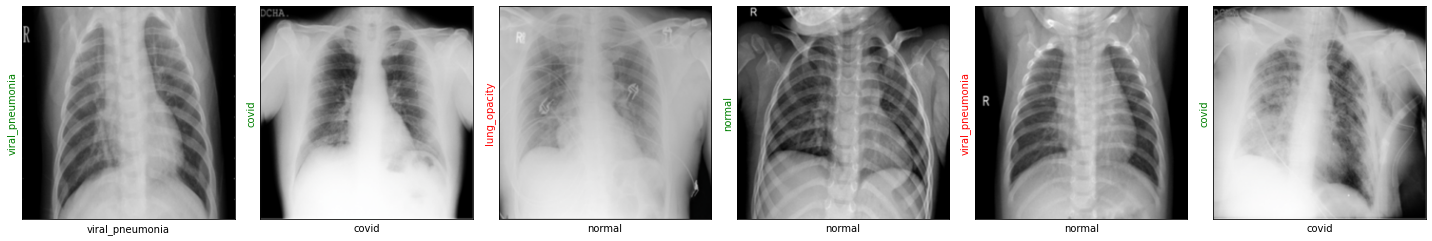

Performance condition satisfied, stopping..
Wall time: 3min 45s


In [16]:
%%time

train(epochs=1)

# Final Results

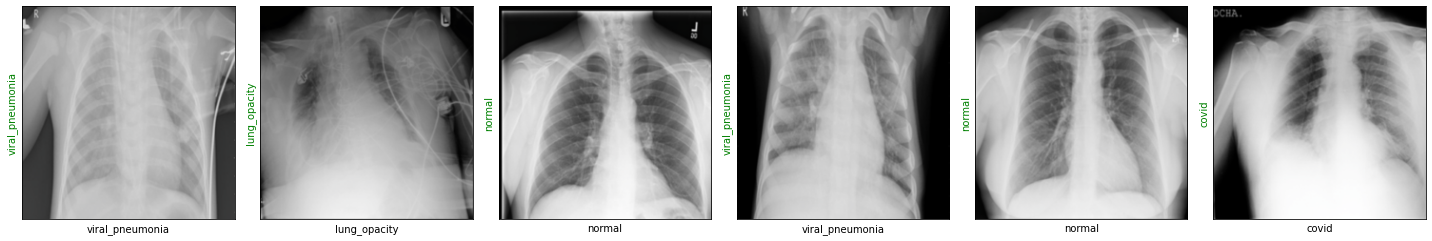

In [17]:
show_preds()

# Metrics

## Data preparation


In [79]:
import torch.nn.functional as F
from torchmetrics import ConfusionMatrix
classes =('Normal','Lung Opacity','Pneumonia','COVID-19')
test_pred_labels = []
test_true_labels = []
train_pred_labels = []
train_true_labels = []
ps_list = []
ps_list_train = []
running_correct = 0.0
running_total = 0.0
running_correct_train = 0.0
running_total_train = 0.0
accuracy_test=0.0
accuracy_train=0.0

def data_extraction(pred_label,true_label,ps_label,dataset,correct,total,accuracy):
    #total=0.0
    #correct=0.0
    with torch.no_grad():
        for images, labels in dataset:
            output = resnet18(images)
            ps = F.softmax(output, dim=1)
            output = (torch.max(torch.exp(output), 1)[1]).numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            #ps = ps.data.cpu().numpy().squeeze()
            #ps_label.extend(np.max(ps))
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct/total
        return pred_label,true_label,ps_label,dataset,correct,total,accuracy

In [80]:

one=data_extraction(test_pred_labels,test_true_labels,ps_list,dl_test,running_correct,running_total,accuracy_test)

target_test = torch.tensor(one[1])
preds_test = torch.tensor(one[0])
confmat = ConfusionMatrix(num_classes=4)
mat_tensor = confmat(preds_test, target_test)
print(mat_tensor)

tensor([[19.,  0.,  0.,  1.],
        [ 1., 33.,  0.,  0.],
        [ 3.,  0., 31.,  1.],
        [ 0.,  0.,  0., 31.]])


In [ ]:
two=data_extraction(train_pred_labels,train_true_labels,ps_list_train,dl_train,running_correct_train,running_total_train,accuracy_train)

target_train = torch.tensor(two[1])
preds_train = torch.tensor(two[0])
confmat2 = ConfusionMatrix(num_classes=4)
mat_tensor2 = confmat2(preds_train, target_train)

print(mat_tensor2)

## Accuracy

In [81]:
print("Total Correct Images: {}, Total Test Images: {}".format(int(one[4]), int(one[5])))
print("Test Accuracy: ", one[6])

Total Correct Images: 114, Total Test Images: 120
Test Accuracy:  0.95


## Confussion Matrix

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
def confutio(mat_tensor,name):
    conf_mat = mat_tensor.numpy()
    group_names = ['True Pos Normal','False Neg','False Neg','False Neg',
                   'False Neg','True Pos Lung','False Neg','False Neg',
                   'False Neg','False Neg','True Pos Pneumonia','False Neg',
                   'False Neg','False Neg','False Neg','True Pos COVID']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(conf_mat, annot=labels, fmt='',ax=ax)
    ax.set_title(label=name+' Confussion Matrix')
    ax.plot
    fig.savefig(name+'_confussion.png')

### Confussion Matrix Test

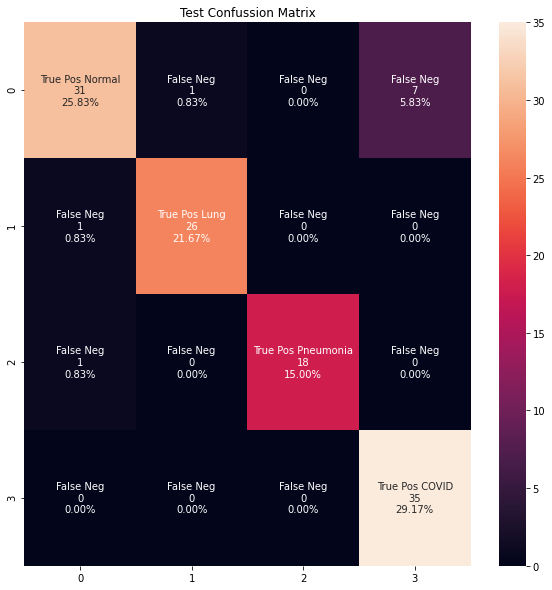

In [58]:
confutio(mat_tensor,'Test')

### Confussion Matrix Train

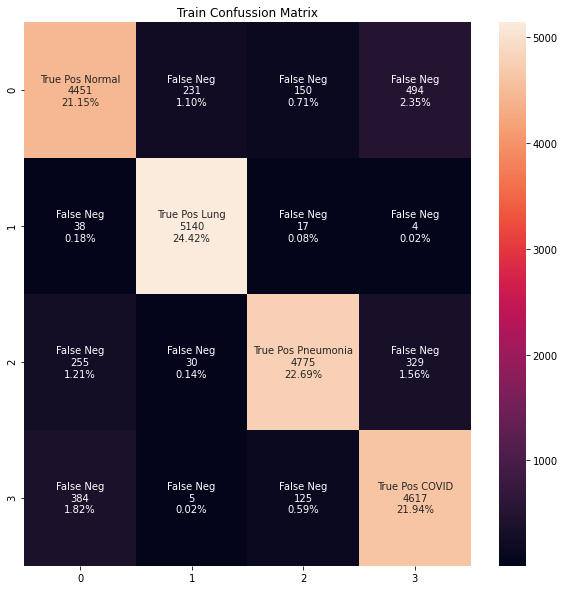

In [43]:
confutio(mat_tensor2,'Train')

## Precision, Recall, F1 Score & Support

In [82]:
import sklearn.metrics as metrics
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(one[1], one[0],target_names=["Normal","Lung opacity","Pneumonia","COVID-19"])))

Classification report for test set:
              precision    recall  f1-score   support

      Normal       0.83      0.95      0.88        20
Lung opacity       1.00      0.97      0.99        34
   Pneumonia       1.00      0.89      0.94        35
    COVID-19       0.94      1.00      0.97        31

    accuracy                           0.95       120
   macro avg       0.94      0.95      0.94       120
weighted avg       0.96      0.95      0.95       120




## GradCAM

In [249]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import deprocess_image
def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def plot_gradcam(image, res_cam):
    image = deprocess_image(image)
    name_dict = {
        'Original Image': image,

        'GradCAM (ResNet-18)': apply_mask(image, res_cam)

    }

    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=(10, 4))
    for i, (name, img) in enumerate(name_dict.items()):
        ax = fig.add_subplot(1, 2, i+1, xticks=[], yticks=[])
        if i:
            img = img[:, :, ::-1]
        ax.imshow(img)
        ax.set_xlabel(name, fontweight='bold')

    fig.suptitle(
        'Localization with Gradient based Class Activation Maps',
        fontweight='bold', fontsize=16
    )
    plt.tight_layout()
    fig.savefig('grad_cam.png')
    plt.show()
    plt.close()


def show_images2(images, labels, preds,res_cam):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):

        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        #image = image.numpy().transpose((1, 2, 0))
        image = image.cpu().numpy()
        image=np.squeeze(np.transpose(image[0], (1, 2, 0)))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        image=apply_mask(image, res_cam[i][1])
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


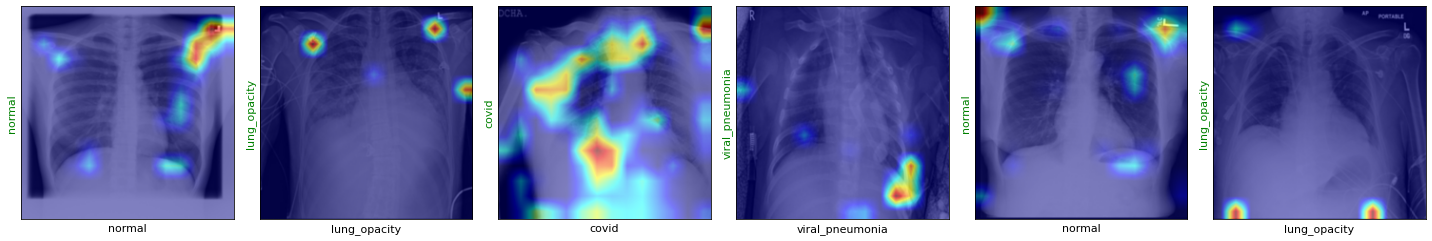

In [267]:
from grad_cam import GradCAM
res_cam=[]
resnet18.eval()
images, labels = next(iter(dl_test))
outputs = resnet18(images)
_, preds = torch.max(outputs, 1)

cam_obj = GradCAM(model=resnet18, target_layer=resnet18.layer3[-1])
for x,image in enumerate (images):
    image=image.unsqueeze(dim=0).cpu()
    res_cam.append(cam_obj(image, int(labels[x].numpy())))

plt.figure(figsize=(20,10))
for i, image in enumerate(images):
    plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
    #image = image.numpy().transpose((1, 2, 0))
    image = image.cpu().numpy()
    image = np.transpose(image,(1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0., 1.)
    image=apply_mask(image, res_cam[i][1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    col = 'green'
    if preds[i] != labels[i]:
        col = 'red'
    plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
plt.tight_layout()
plt.savefig('grad_cam_test.png')
plt.show()


#show_images2(images,labels,preds,res_cam)
#plot_gradcam(images[0].unsqueeze(dim=0).cpu(),res_cam[0][1])

## Area Under the Curve

In [23]:
from torchmetrics import ROC
from torchmetrics import AUROC
from matplotlib import pyplot


roc = ROC(num_classes=4)
auroc = AUROC(num_classes=4)

# define a tensor with probabilities
pred = torch.tensor(ps_list, dtype=torch.float64)
# define a tensor with
target =  torch.tensor(test_true_labels, dtype=torch.int64)

fpr, tpr, _ = roc(pred, target)

#roc_auc = auroc(pred, target).item()
'''
pyplot.plot([0, 1], [0, 1], linestyle='--', label='')
pyplot.title('ROC curve (area = %0.2f)' % roc_auc)

pyplot.plot(fpr, tpr, marker='.', label='ROC curve')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()
'''

c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ValueError: preds and target must have same number of dimensions, or one additional dimension for preds

# Intermediate Layers